In [297]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.metrics import classification_report_imbalanced
#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from imblearn.under_sampling import NearMiss

### Load binary unbalanced data

In [276]:
def binaryBalancedData():
    file = 'Datasets/diabetes_binary_health_indicators_BRFSS2015.csv'
    df = pd.read_csv(file)
    
    #Drop duplicates
    df.drop_duplicates(inplace=True)
    
    #Change all column names to lower case
    df.columns = df.columns.str.lower().str.replace('diabetes_binary','diabetes')

    return df

def splitDF(df):    
    target = df.diabetes
    data = df.drop(columns=['diabetes'])
    dfTrainFull, dfTest, yTrainFull, yTest = train_test_split(data, target, test_size=0.2, random_state=11)
    dfTrain, dfVal, yTrain, yVal = train_test_split(data, target, test_size=0.25, random_state=11)
    return dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest


In [277]:
df = binaryBalancedData()
#dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal,yVal, dfTest, yTest = splitDF(df)
df.head()

,diabetes,highbp,highchol,cholcheck,bmi,smoker,stroke,heartdiseaseorattack,physactivity,fruits,...,anyhealthcare,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### EDA

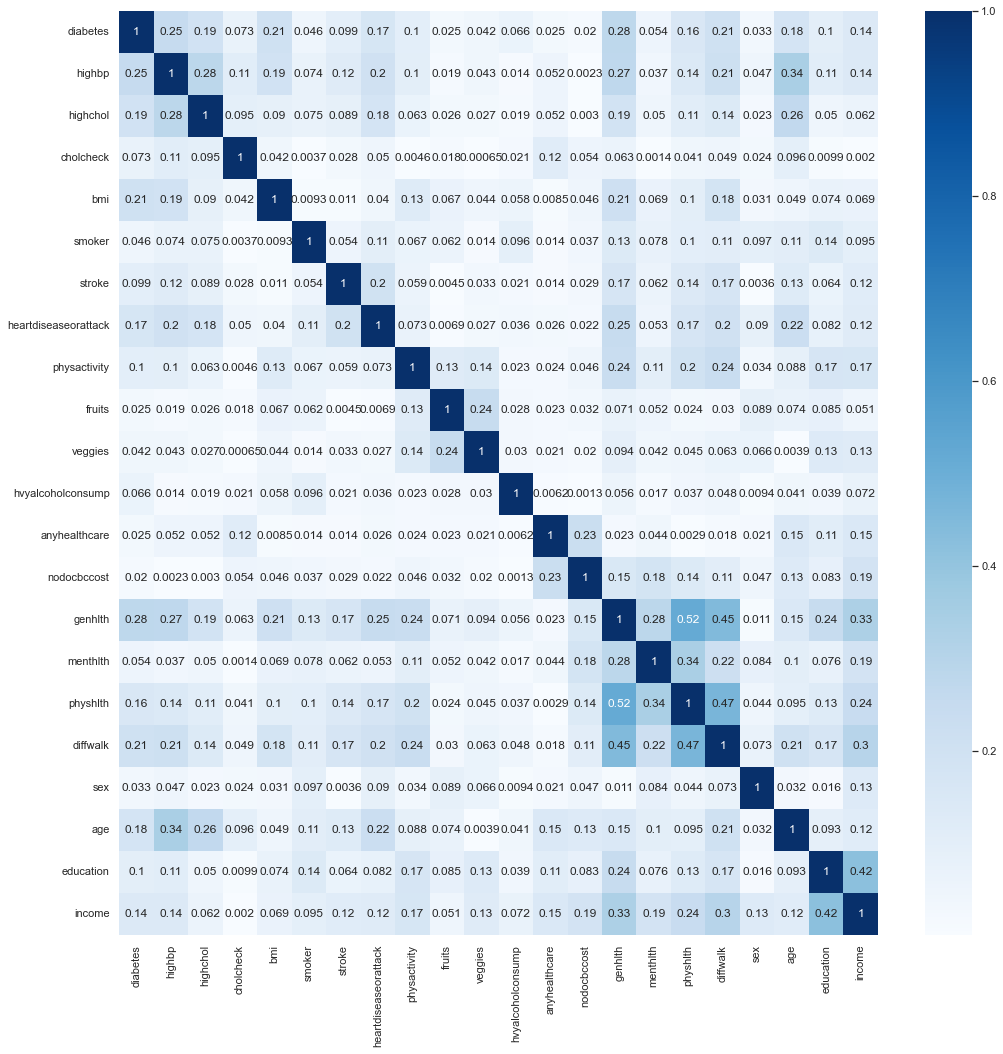

In [4]:
sns.set_theme()
corr_matrix = df.corr().abs()
plt.figure(figsize=(17,17))

_ = sns.heatmap(corr_matrix, cmap="Blues", annot=True)

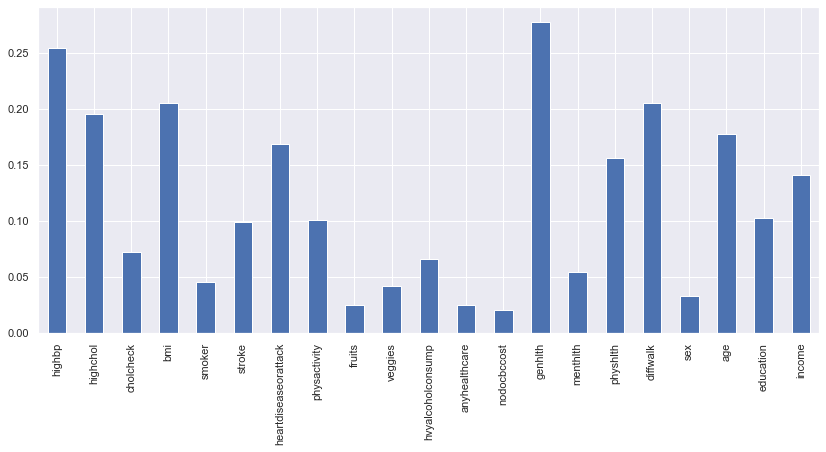

In [5]:
#corr_matrix.diabetes.sort_values(ascending=False).hist()
sns.set_theme()
corr_matrix = df.drop(columns='diabetes').corrwith(df.diabetes).abs()
plt.figure(figsize=(14,6))
_ = corr_matrix.plot(kind='bar', grid=True)

In [6]:
corr_matrix.sort_values(ascending=False)

genhlth                 0.276940
highbp                  0.254318
diffwalk                0.205302
bmi                     0.205086
highchol                0.194944
age                     0.177263
heartdiseaseorattack    0.168213
physhlth                0.156211
income                  0.140659
education               0.102686
physactivity            0.100404
stroke                  0.099193
cholcheck               0.072523
hvyalcoholconsump       0.065950
menthlth                0.054153
smoker                  0.045504
veggies                 0.041734
sex                     0.032724
anyhealthcare           0.025331
fruits                  0.024805
nodocbccost             0.020048
dtype: float64

In [278]:
newdf = df.drop(columns=['nodocbccost', 'fruits', 'anyhealthcare', 'sex', 'veggies', 'smoker', 'menthlth','physhlth'])

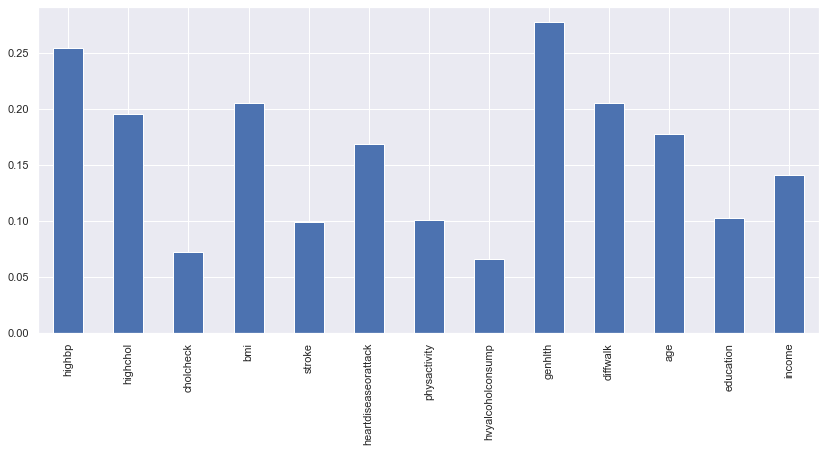

In [20]:
#corr_matrix.diabetes.sort_values(ascending=False).hist()
sns.set_theme()
corr_matrix = newdf.drop(columns='diabetes').corrwith(newdf.diabetes).abs()
plt.figure(figsize=(14,6))
_ = corr_matrix.plot(kind='bar', grid=True)

#### The target value is heavily imbalanced.  No Diabetes- 194377, Diabetes- 35097.

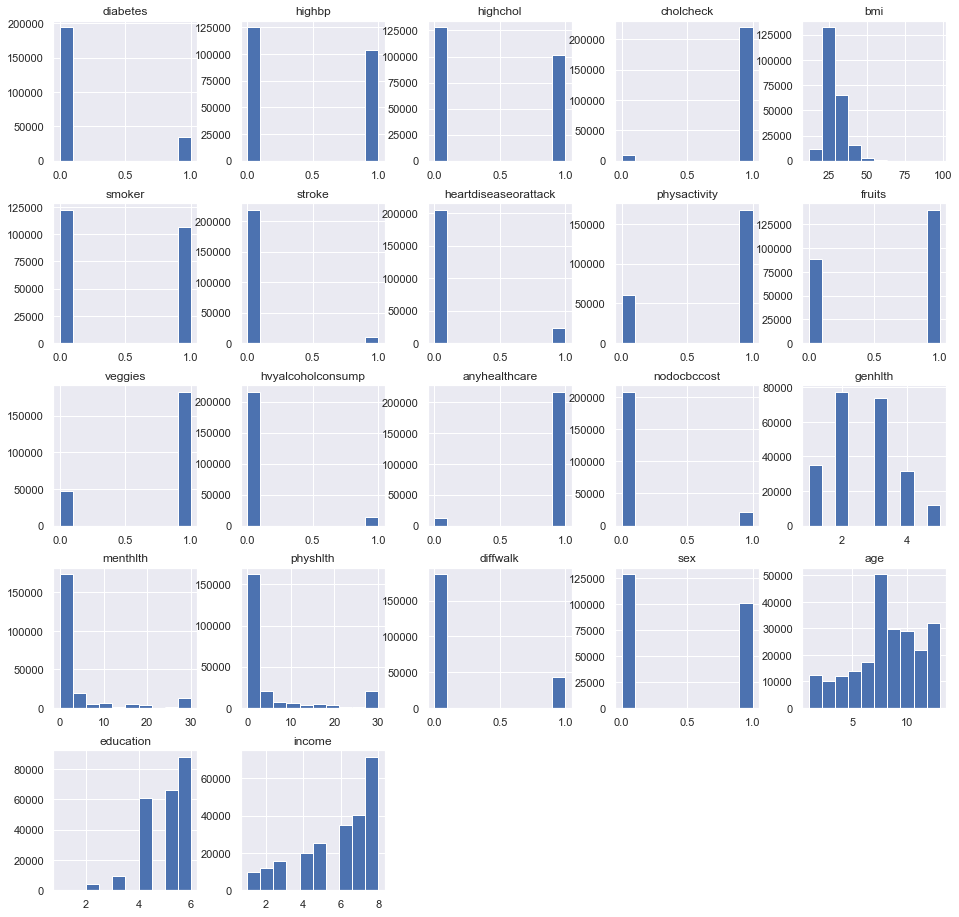

In [58]:
_= df.hist(figsize=(16,16))

In [279]:
dfTrainFull, yTrainFull, dfTrain, yTrain, dfVal, yVal, dfTest, yTest = splitDF(newdf)

### Preprocessing

In [ ]:
categoricalCols = ['highbp', 'highchol', 'cholcheck','smoker',
       'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies',
       'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'genhlth','diffwalk', 'sex', 'education']

numericalCols = ['bmi', 'menthlth', 'physhlth', 'income']

In [ ]:
#dfTrain.income = np.log1p(dfTrain.income)

In [ ]:
# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    #('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")
    #('one-hot-encoder', catPreprocessor, categoricalCols),('standard_scaler', numPreprocessor, numericalCols)])
    ], remainder="passthrough")


### DecisionTreeClassifier

In [280]:
# creating the model
from sklearn.pipeline import make_pipeline
model = make_pipeline(DecisionTreeClassifier(max_depth=7,
                                             max_leaf_nodes=25,
                                             class_weight='balanced',
                                             max_features=9,
                                             random_state=1))

model.fit(dfTrain, yTrain)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=7,
                                        max_features=9, max_leaf_nodes=25,
                                        random_state=1))])

In [281]:
yValPred = model.predict_proba(dfVal)[:,1]
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')
auc = roc_auc_score(yVal, yValPred)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test prediction: {yTestpred}')
print(f'Test RMSE: {mean_squared_error(yTest, yTestpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPred = model.predict_proba(dfTrain)[:,1]
print(f'Train prediction: {yTrainPred}')
print(f'Train RMSE: {mean_squared_error(yTrain, yTrainPred,squared=False)}')
auc = roc_auc_score(yTrain, yTrainPred)
print(f'Train AUC: {auc}')

print(classification_report(yVal, model.predict(dfVal)))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

Val prediction: [0.76025246 0.23550522 0.32480217 ... 0.15757552 0.56159158 0.53527312]
Val RMSE: 0.4411888963750796
Val AUC: 0.7827769023353429
Test prediction: [0.76025246 0.23550522 0.32480217 ... 0.83752917 0.15991509 0.37102355]
Test RMSE: 0.44109762162890237
Test AUC: 0.7834382137797613
Train prediction: [0.15991509 0.32480217 0.83752917 ... 0.32480217 0.23550522 0.42782286]
Train RMSE: 0.4395337168109378
Train AUC: 0.7882035054891436
              precision    recall  f1-score   support

         0.0       0.94      0.68      0.79     48590
         1.0       0.30      0.75      0.42      8779

    accuracy                           0.69     57369
   macro avg       0.62      0.71      0.61     57369
weighted avg       0.84      0.69      0.73     57369

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.94      0.68      0.75      0.79      0.71      0.50     48590
        1.0       0.30      0.75      0.68      0.42      0.7

In [282]:
cv_results = cross_validate(model, dfTrain, yTrain,cv=5,
                            scoring=['roc_auc', 'average_precision','recall','f1', 'accuracy','balanced_accuracy'])
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_roc_auc,test_average_precision,test_recall,test_f1,test_accuracy,test_balanced_accuracy
0,0.142015,0.064000,0.788776,0.373111,0.737792,0.434802,0.706720,0.719452
1,0.136988,0.060012,0.787507,0.369017,0.749002,0.434213,0.701548,0.720993
2,0.133013,0.061759,0.785070,0.363980,0.753989,0.423609,0.686209,0.713981
3,0.136747,0.060675,0.786080,0.363455,0.765388,0.428071,0.687226,0.719251
4,0.135985,0.063014,0.785143,0.361510,0.718655,0.436005,0.715668,0.716892


In [283]:
cvCols = cv_results.columns.values
x = cv_results.mean(axis=0).round(4)
y = cv_results.std(axis=0).round(4)
print('--- Scores ---')
for i,j,k in list(zip(cvCols,x,y)):
    print(f'{i}: {j} +/- {k}')

--- Scores ---
fit_time: 0.1369 +/- 0.0032
score_time: 0.0619 +/- 0.0016
test_roc_auc: 0.7865 +/- 0.0016
test_average_precision: 0.3662 +/- 0.0047
test_recall: 0.745 +/- 0.0177
test_f1: 0.4313 +/- 0.0053
test_accuracy: 0.6995 +/- 0.0127
test_balanced_accuracy: 0.7181 +/- 0.0027


In [284]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([("classifier", DecisionTreeClassifier(class_weight='balanced', random_state=1 ))])
param_grid = {
    'classifier__max_depth': (1, 3,5,7,10,12),
    'classifier__max_leaf_nodes': (1, 5,10,15,20,25),
    'classifier__max_features': (1,3,4,5,7,9,10)
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=5)
model_grid_search.fit(dfTrain, yTrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=1))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': (1, 3, 5, 7, 10, 12),
                         'classifier__max_features': (1, 3, 4, 5, 7, 9, 10),
                         'classifier__max_leaf_nodes': (1, 5, 10, 15, 20, 25)},
             scoring='roc_auc')

In [285]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results[[
    "param_classifier__max_depth",
    'param_classifier__max_leaf_nodes',
    "param_classifier__max_features",
    "mean_test_score",
    "std_test_score",
    "rank_test_score"
]]

,param_classifier__max_depth,param_classifier__max_leaf_nodes,param_classifier__max_features,mean_test_score,std_test_score,rank_test_score
0,1,1,1,NaN,NaN,252
1,1,5,1,0.570860,0.002003,206
2,1,10,1,0.570860,0.002003,206
3,1,15,1,0.570860,0.002003,206
4,1,20,1,0.570860,0.002003,206
...,...,...,...,...,...,...
247,12,5,10,0.747421,0.004158,113
248,12,10,10,0.768507,0.003714,68
249,12,15,10,0.776702,0.001853,38
250,12,20,10,0.781834,0.001717,16


In [286]:
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
245,0.636950,0.041583,0.024799,0.002484,12,9,25,"{'classifier__max_depth': 12, 'classifier__max...",0.788776,0.787507,0.785070,0.786080,0.785143,0.786515,0.001432,1
203,0.610200,0.035581,0.028606,0.007057,10,9,25,"{'classifier__max_depth': 10, 'classifier__max...",0.788776,0.787507,0.785070,0.786080,0.785143,0.786515,0.001432,1
161,0.590601,0.018748,0.021202,0.000747,7,9,25,"{'classifier__max_depth': 7, 'classifier__max_...",0.788776,0.787507,0.785070,0.786080,0.785143,0.786515,0.001432,1
119,0.563278,0.013804,0.026401,0.002153,5,9,25,"{'classifier__max_depth': 5, 'classifier__max_...",0.789894,0.786769,0.784693,0.784655,0.782823,0.785767,0.002412,4
125,0.586159,0.016613,0.029203,0.007408,5,10,25,"{'classifier__max_depth': 5, 'classifier__max_...",0.788802,0.786228,0.785740,0.783957,0.781516,0.785248,0.002426,5


In [287]:
model_grid_search.best_params_

{'classifier__max_depth': 7,
 'classifier__max_features': 9,
 'classifier__max_leaf_nodes': 25}

In [290]:
model_grid_search.fit(dfTrainFull, yTrainFull)
accuracy = model_grid_search.score(dfTest, yTest)
print(f"AUC on test set: {accuracy:.3f}")

AUC on test set: 0.786


In [291]:
cv_results = cross_validate(
    model_grid_search, dfTrainFull, yTrainFull, cv=5, n_jobs=2, return_estimator=True
)

In [293]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results['test_score']
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.786 ± 0.001


In [294]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__max_depth': 7, 'classifier__max_features': 9, 'classifier__max_leaf_nodes': 25}
Best hyperparameters for fold #2:
{'classifier__max_depth': 7, 'classifier__max_features': 9, 'classifier__max_leaf_nodes': 25}
Best hyperparameters for fold #3:
{'classifier__max_depth': 7, 'classifier__max_features': 9, 'classifier__max_leaf_nodes': 25}
Best hyperparameters for fold #4:
{'classifier__max_depth': 7, 'classifier__max_features': 9, 'classifier__max_leaf_nodes': 25}
Best hyperparameters for fold #5:
{'classifier__max_depth': 7, 'classifier__max_features': 9, 'classifier__max_leaf_nodes': 25}


In [305]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeClassifier(random_state=0)
cv_results = cross_validate(tree, dfTrainFull, yTrainFull, n_jobs=2)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

R2 score obtained by cross-validation: 0.799 ± 0.002


In [311]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    "max_depth": [5, 8, None],
    "min_samples_split": [2, 10, 30, 50],
    "min_samples_leaf": [0.01, 0.05, 0.1, 1]}
cv = 3

tree = GridSearchCV(DecisionTreeClassifier(random_state=0),
                    param_grid=param_grid, cv=cv, n_jobs=2)
cv_results = cross_validate(tree, dfTrainFull, yTrainFull, n_jobs=-1,
                            return_estimator=True)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

R2 score obtained by cross-validation: 0.851 ± 0.001
Wall time: 30.8 s


In [313]:
%%time
from sklearn.ensemble import BaggingRegressor

base_estimator = DecisionTreeClassifier(random_state=0, max_depth=7, max_features=9, max_leaf_nodes=20)
bagging_regressor = BaggingRegressor(base_estimator=base_estimator, n_estimators=20, random_state=0)

cv_results = cross_validate(bagging_regressor, dfTrain, yTrain, n_jobs=-1)
scores = cv_results["test_score"]

print(f"R2 score obtained by cross-validation: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

R2 score obtained by cross-validation: -0.086 ± 0.009
Wall time: 4.1 s


In [250]:
for i in model_grid_search.get_params():
    print(i)

cv
error_score
estimator__memory
estimator__steps
estimator__verbose
estimator__classifier
estimator__classifier__ccp_alpha
estimator__classifier__class_weight
estimator__classifier__criterion
estimator__classifier__max_depth
estimator__classifier__max_features
estimator__classifier__max_leaf_nodes
estimator__classifier__min_impurity_decrease
estimator__classifier__min_samples_leaf
estimator__classifier__min_samples_split
estimator__classifier__min_weight_fraction_leaf
estimator__classifier__random_state
estimator__classifier__splitter
estimator
n_jobs
param_grid
pre_dispatch
refit
return_train_score
scoring
verbose


In [251]:
model_grid_search

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('classifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=1))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': (1, 20),
                         'classifier__max_features': (1, 7),
                         'classifier__max_leaf_nodes': (1, 35)},
             scoring='roc_auc')

### Logistic Regression

In [314]:
#model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))    
model = make_pipeline(StandardScaler(),LogisticRegression(max_iter=1000))    

#model.fit(dfTrain[0:size], yTrain[0:size])
model.fit(dfTrain, yTrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [315]:
yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
print(f'Val prediction: {yValPredProba}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPredProba,squared=False)}')
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test prediction: {yTestpred}')
print(f'Test RMSE: {mean_squared_error(yTest, yTestpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')


yTrainPredProba = model.predict_proba(dfTrain)[:,1]
yTrainPred = model.predict(dfTrain)
print(f'Train prediction: {yTrainPredProba}')
print(f'Val RMSE: {mean_squared_error(yTrain, yTrainPredProba,squared=False)}')
auc = roc_auc_score(yTrain, yTrainPredProba)
print(f'Train AUC: {auc}')

print(classification_report(yVal, yValPred))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

Val prediction: [0.30462698 0.03094894 0.04608061 ... 0.00691396 0.17597213 0.08261871]
Val RMSE: 0.3295731618119864
Val AUC: 0.8032454562552815
Test prediction: [0.30462698 0.03094894 0.04608061 ... 0.30328742 0.02783216 0.16631864]
Test RMSE: 0.32886001720076663
Test AUC: 0.8042802088320266
Train prediction: [0.04728425 0.11403591 0.82853644 ... 0.08985838 0.0806126  0.27812105]
Val RMSE: 0.32924415495055215
Train AUC: 0.8058861251927483
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     48590
         1.0       0.55      0.15      0.23      8779

    accuracy                           0.85     57369
   macro avg       0.70      0.56      0.57     57369
weighted avg       0.82      0.85      0.81     57369

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.86      0.98      0.15      0.92      0.38      0.16     48590
        1.0       0.55      0.15      0.98      0.23      0.38

### Logistic Regression 2

In [326]:
#model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))    
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000,
                                                           class_weight='balanced',
                                                           random_state=1 ))    

#model.fit(dfTrain[0:size], yTrain[0:size])
model.fit(dfTrain, yTrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=1))])

In [327]:
yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test prediction: {yTestpred}')
print(f'Test RMSE: {mean_squared_error(yTest, yTestpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = model.predict_proba(dfTrain)[:,1]
yTrainPred = model.predict(dfTrain)
print(f'Train prediction: {yTrainPred}')
print(f'Train RMSE: {mean_squared_error(yTrain, yTrainPred,squared=False)}')
auc = roc_auc_score(yTrain, yTrainPredProba)
print(f'Train AUC: {auc}')

print(classification_report(yVal, yValPred))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

Val prediction: [1. 0. 0. ... 0. 1. 0.]
Val RMSE: 0.5308059483149294
Val AUC: 0.8036682715476542
Test prediction: [0.70999921 0.12685449 0.19106893 ... 0.71870243 0.12555132 0.5513347 ]
Test RMSE: 0.42864620031639505
Test AUC: 0.8046867532466233
Train prediction: [0. 0. 1. ... 0. 0. 1.]
Train RMSE: 0.5320499894272416
Train AUC: 0.8064062230397826
              precision    recall  f1-score   support

         0.0       0.94      0.71      0.81     48590
         1.0       0.32      0.75      0.45      8779

    accuracy                           0.72     57369
   macro avg       0.63      0.73      0.63     57369
weighted avg       0.85      0.72      0.76     57369

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.94      0.71      0.75      0.81      0.73      0.53     48590
        1.0       0.32      0.75      0.71      0.45      0.73      0.53      8779

avg / total       0.85      0.72      0.74      0.76      0.73      0.53 

### Logistic regression 3

In [328]:
steps = [ ('scale', StandardScaler()), ('model', LogisticRegression(max_iter=1000,class_weight='balanced'))]
#StandardScaler().fit(dfTrainFull)
#pipeline = make_pipeline(StandardScaler(), LogisticRegression())
Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2)
scores = pd.DataFrame.from_dict( cross_validate(pipeline, dfTrain, yTrain, cv=cv,
                         scoring=('f1', 
                                  'recall' , 
                                  'precision', 
                                  'precision_micro',
                                  'accuracy', 
                                  'roc_auc'),
                         return_train_score=True))
                                
scores = scores.mean(axis=0)     
scores

fit_time                 0.224132
score_time               0.076503
test_f1                  0.228689
train_f1                 0.229402
test_recall              0.145585
train_recall             0.146079
test_precision           0.533137
train_precision          0.534061
test_precision_micro     0.849833
train_precision_micro    0.849933
test_accuracy            0.849833
train_accuracy           0.849933
test_roc_auc             0.805761
train_roc_auc            0.805899
dtype: float64

In [329]:
pipeline.steps[0][1].fit(dfTrain)
pipeline.steps[1][1].fit(dfTrain, yTrain)

yValPredProba = pipeline.predict_proba(dfVal)[:,1]
yValPred = pipeline.predict(dfVal)
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=pipeline.predict_proba(dfTest)[:,1]
print(f'Test prediction: {yTestpred}')
print(f'Test RMSE: {mean_squared_error(yTest, yTestpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = pipeline.predict_proba(dfTrain)[:,1]
yTrainPred = pipeline.predict(dfTrain)
print(f'Train prediction: {yTrainPred}')
print(f'Train RMSE: {mean_squared_error(yTrain, yTrainPred,squared=False)}')
print(f'Train AUC: {auc}')

print(classification_report(yVal, yValPred))

print(classification_report_imbalanced(yVal, pipeline.predict(dfVal)))

Val prediction: [0. 0. 0. ... 0. 0. 0.]
Val RMSE: 0.39118652336046433
Val AUC: 0.7737616985340399
Test prediction: [0.03298722 0.00942904 0.001982   ... 0.02040136 0.00053951 0.00237135]
Test RMSE: 0.38044505500974635
Test AUC: 0.7745922524182923
Train prediction: [0. 0. 0. ... 0. 0. 0.]
Train RMSE: 0.39104766542385916
Train AUC: 0.7737616985340399
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92     48590
         1.0       0.00      0.00      0.00      8779

    accuracy                           0.85     57369
   macro avg       0.42      0.50      0.46     57369
weighted avg       0.72      0.85      0.78     57369

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.85      1.00      0.00      0.92      0.00      0.00     48590
        1.0       0.00      0.00      1.00      0.00      0.00      0.00      8779

avg / total       0.72      0.85      0.15      0.78      0.00      0.0

### Random Forest

In [330]:
model = make_pipeline(RandomForestClassifier(n_estimators=10,
                                             random_state=1,
                                             max_depth=6,
                                             max_features=7,
                                             class_weight='balanced'))
model.fit(dfTrain, yTrain)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        max_features=7, n_estimators=10,
                                        random_state=1))])

In [331]:
#yValPred = RF.predict_proba(dfVal)[:,1]

#roc_auc_score(yVal, yValPred)

yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test prediction: {yTestpred}')
print(f'Test RMSE: {mean_squared_error(yTest, yTestpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = model.predict_proba(dfTrain)[:,1]
yTrainPred = model.predict(dfTrain)
print(f'Train prediction: {yTrainPred}')
print(f'Train RMSE: {mean_squared_error(yTrain, yTrainPredProba,squared=False)}')
print(f'Train AUC: {auc}')



print(classification_report(yVal, model.predict(dfVal)))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

Val prediction: [1. 0. 0. ... 0. 1. 0.]
Val RMSE: 0.5454311715449086
Val AUC: 0.8019266776802141
Test prediction: [0.7699782  0.3292201  0.15771526 ... 0.74316077 0.10322591 0.43401111]
Test RMSE: 0.43113319867523914
Test AUC: 0.8022787577099452
Train prediction: [0. 0. 1. ... 0. 0. 0.]
Train RMSE: 0.4300845252246288
Train AUC: 0.8019266776802141
              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80     48590
         1.0       0.31      0.76      0.44      8779

    accuracy                           0.70     57369
   macro avg       0.63      0.73      0.62     57369
weighted avg       0.84      0.70      0.74     57369

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.94      0.69      0.76      0.80      0.73      0.52     48590
        1.0       0.31      0.76      0.69      0.44      0.73      0.53      8779

avg / total       0.84      0.70      0.75      0.74      0.73      0.52 

### HistGradientBoostingClassifier

In [332]:
model = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(random_state=1,
                                                     max_depth=5,
                                                     max_leaf_nodes=10))
model.fit(dfTrain, yTrain)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(max_depth=5, max_leaf_nodes=10,
                                                random_state=1))])

In [333]:
yValPredProba = model.predict_proba(dfVal)[:,1]
yValPred = model.predict(dfVal)
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')
auc = roc_auc_score(yVal, yValPredProba)
print(f'Val AUC: {auc}')

yTestpred=model.predict_proba(dfTest)[:,1]
print(f'Test prediction: {yTestpred}')
print(f'Test RMSE: {mean_squared_error(yTest, yTestpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

yTrainPredProba = model.predict_proba(dfTrain)[:,1]
yTrainPred = model.predict(dfTrain)
print(f'Train prediction: {yTrainPred}')
print(f'Train RMSE: {mean_squared_error(yTrain, yTrainPredProba,squared=False)}')
print(f'Train AUC: {auc}')



print(classification_report(yVal, model.predict(dfVal)))
print(classification_report_imbalanced(yVal, model.predict(dfVal)))

Val prediction: [0. 0. 0. ... 0. 0. 0.]
Val RMSE: 0.38278600655019623
Val AUC: 0.8117771163908446
Test prediction: [0.31623717 0.02310876 0.04495947 ... 0.3653924  0.01892159 0.16530097]
Test RMSE: 0.32533251587386647
Test AUC: 0.8120825977694843
Train prediction: [0. 0. 1. ... 0. 0. 0.]
Train RMSE: 0.32464297836364453
Train AUC: 0.8117771163908446
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     48590
         1.0       0.58      0.15      0.24      8779

    accuracy                           0.85     57369
   macro avg       0.72      0.57      0.58     57369
weighted avg       0.82      0.85      0.82     57369

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.87      0.98      0.15      0.92      0.39      0.16     48590
        1.0       0.58      0.15      0.98      0.24      0.39      0.14      8779

avg / total       0.82      0.85      0.28      0.82      0.39      0.1

### XGBoost

In [105]:
dTrain = xgb.DMatrix(dfTrain, yTrain)#, enable_categorical=True)
dVal = xgb.DMatrix(dfVal, yVal)#, enable_categorical=True)
dTest = xgb.DMatrix(dfTest, yTest)#, enable_categorical=True)
xgbParams = {
'eta': 0.05,
'max_depth': 10,
'min_child_weight': 1,

'objective': 'binary:logistic',
'nthreads': 8,

'seed': 1,
'verbosity': 1,
}

model = xgb.train(xgbParams, dTrain, num_boost_round=10)

yValPred = model.predict(dVal)

#roc_auc_score(yVal, yValPred)

#model.fit(dfTrain, yTrain)
#yValPred = model.predict_proba(dfVal)[:,1]
#yValPred = model.predict(dfVal)#[:,1]
#yValPred = np.argmax(resdfVal, axis=1)
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')
print(f'Val AUC: {roc_auc_score(yVal,yValPred)}')

yTestpred = model.predict(dTest)
print(f'Test prediction: {yTestpred}')
print(f'Test RMSE: {mean_squared_error(yTest, yTestpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, yTestpred)}')

#yTrainPred = model.predict_proba(dfTrain)[:,1]
#yTrainPred = model.predict(dfTrain)#[:,1]
yTrainPred = model.predict(dTrain)
#yTrainPred = np.argmax(resdfValPred, axis=1)
print(f'Train prediction: {yTrainPred}')
print(f'Train RMSE: {mean_squared_error(yTrain, yTrainPred,squared=False)}')
print(f'Train AUC: {roc_auc_score(yTrain,yTrainPred)}')

print(classification_report(yVal, (yValPred > 0.5).astype(int)))
print(classification_report_imbalanced(yVal, (yValPred > 0.5).astype(int)))

[21:51:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "nthreads" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Val prediction: [0.43168455 0.32745036 0.31596875 ... 0.30761865 0.3806628  0.3349177 ]
Val RMSE: 0.39854716536744134
Val AUC: 0.8038438223772087
Test prediction: [0.43168455 0.32745036 0.31596875 ... 0.43888757 0.31089965 0.3572546 ]
Test RMSE: 0.39838144897405425
Test AUC: 0.8034959633017529
Train prediction: [0.30981466 0.32410908 0.6109144  ... 0.32561126 0.3246002  0.34965733]
Train RMSE: 0.3961242824435164
Train AUC: 0.8257711833764676
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     48590
         1.0       0.57     

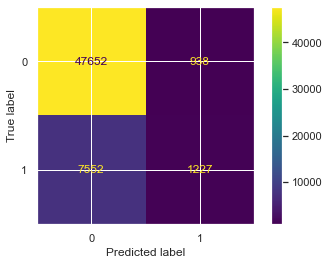

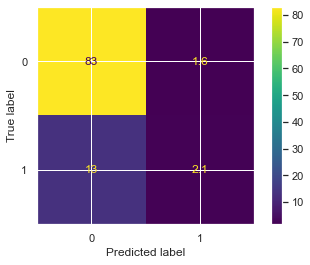

In [106]:
cm = confusion_matrix(yVal, (yValPred > 0.5).astype(int))
cmprob = np.round(100 * cm / len(yVal), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['0', '1']).plot()

In [ ]:
# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")
    #('one-hot-encoder', catPreprocessor, categoricalCols),
    #('standard_scaler', numPreprocessor, numericalCols)])
    


In [ ]:
# creating the model
from sklearn.pipeline import make_pipeline
model = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30))

model.fit(dfTrain, yTrain)

### UnderSampling

In [ ]:
df, _,_,_,_,_,_,_,_ = binaryBalancedData()
target = df.diabetes
data = df.drop(columns=['diabetes'])
#nm = NearMiss()
nm = NearMiss(version = 1 , n_neighbors = 5)

X_res, y_res = nm.fit_resample(data, target)
X_res.shape, y_res.shape

In [ ]:
X_trainFull , X_test , Y_trainFull , Y_test = train_test_split(X_res,y_res, test_size=0.2 , random_state=42)
X_train , X_val , Y_train , Y_val = train_test_split(X_res,y_res, test_size=0.25 , random_state=42)

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
X_val = scalar.fit_transform(X_val)

In [ ]:
model = LogisticRegression(max_iter = 1200)
model.fit(X_train , Y_train)

# make predictions on test set
y_pred=model.predict(X_val)

print('Train: {:.2f}'.format(model.score(X_train, Y_train)))

print('Test: {:.2f}'.format(model.score(X_val, Y_val)))

In [ ]:
y_pred=model.predict(X_val)
print(f'Val prediction: {y_pred}')
print(f'Val RMSE: {mean_squared_error(Y_val, y_pred,squared=False)}')
print(f'Val AUC: {roc_auc_score(Y_val,y_pred)}')
print('#######')
y_Testpred=model.predict(X_test)
print(f'Test prediction: {y_Testpred}')
print(f'Test RMSE: {mean_squared_error(Y_test, y_Testpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(Y_test, y_Testpred)}')
print('#######')
y_predTrain=model.predict(X_train)
print(f'Train prediction: {y_predTrain}')
print(f'Train RMSE: {mean_squared_error(Y_train, y_predTrain,squared=False)}')
print(f'Train AUC: {roc_auc_score(Y_train,y_predTrain)}')

cm = confusion_matrix(Y_val, y_pred)
cmprob = np.round(100 * cm / len(Y_val), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['0', '1']).plot()

print(classification_report(Y_val, y_pred))
print(classification_report_imbalanced(Y_val, y_pred))

In [ ]:
y_pred=model.predict(dfVal)
print(f'Val prediction: {y_pred}')
print(f'Val RMSE: {mean_squared_error(yVal, y_pred,squared=False)}')
print(f'Val AUC: {roc_auc_score(yVal, y_pred)}')
print('#######')
y_Testpred=model.predict(dfTest)
print(f'Test prediction: {y_Testpred}')
print(f'Test RMSE: {mean_squared_error(yTest, y_Testpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, y_Testpred)}')
print('#######')
y_predTrain=model.predict(dfTrain)
print(f'Train prediction: {y_predTrain}')
print(f'Train RMSE: {mean_squared_error(yTrain, y_predTrain,squared=False)}')
print(f'Train AUC: {roc_auc_score(yTrain,y_predTrain)}')

cm = confusion_matrix(yVal, y_pred)
cmprob = np.round(100 * cm / len(yVal), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['0', '1']).plot()

print(classification_report(yVal, y_pred))
print(classification_report_imbalanced(yVal, y_pred))

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
target = df.diabetes
data = df.drop(columns=['diabetes'])
#nm = NearMiss()
nm = RandomUnderSampler(random_state=0)

X_res, y_res = nm.fit_resample(data, target)
X_res.shape, y_res.shape

In [ ]:
X_trainFull , X_test , Y_trainFull , Y_test = train_test_split(X_res,y_res, test_size=0.2 , random_state=42)
X_train , X_val , Y_train , Y_val = train_test_split(X_res,y_res, test_size=0.25 , random_state=42)

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
X_val = scalar.fit_transform(X_val)

In [ ]:
lg = LogisticRegression(max_iter = 1200)
lg.fit(X_train , Y_train)

# make predictions on test set
y_pred=lg.predict(X_val)

print('Training set score: {:.4f}'.format(lg.score(X_train, Y_train)))

print('Test set score: {:.4f}'.format(lg.score(X_val, Y_val)))

In [ ]:
y_pred=lg.predict(X_val)
print(f'Val prediction: {y_pred}')
print(f'Val RMSE: {mean_squared_error(Y_val, y_pred,squared=False)}')
print(f'Val AUC: {roc_auc_score(Y_val,y_pred)}')

y_predTest=lg.predict(X_test)
print(f'Test prediction: {y_predTest}')
print(f'Test RMSE: {mean_squared_error(Y_test, y_predTest,squared=False)}')
print(f'Test AUC: {roc_auc_score(Y_test, y_predTest)}') 

y_predTrain=lg.predict(X_train)
print(f'Train prediction: {y_predTrain}')
print(f'Train RMSE: {mean_squared_error(Y_train, y_predTrain,squared=False)}')
print(f'Train AUC: {roc_auc_score(Y_train,y_predTrain)}')

cm = confusion_matrix(Y_val, y_pred)
cmprob = np.round(100 * cm / len(Y_val), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['0', '1']).plot()

print(classification_report(Y_val, y_pred))
print(classification_report_imbalanced(Y_val, y_pred))

In [ ]:
y_pred=lg.predict(dfVal)
print(f'Val prediction: {y_pred}')
print(f'Val RMSE: {mean_squared_error(yVal, y_pred,squared=False)}')
print(f'Val AUC: {roc_auc_score(yVal, y_pred)}')
print('#######')
y_Testpred=lg.predict(dfTest)
print(f'Test prediction: {y_Testpred}')
print(f'Test RMSE: {mean_squared_error(yTest, y_Testpred,squared=False)}')
print(f'Test AUC: {roc_auc_score(yTest, y_Testpred)}')
print('#######')
y_predTrain=lg.predict(dfTrain)
print(f'Train prediction: {y_predTrain}')
print(f'Train RMSE: {mean_squared_error(yTrain, y_predTrain,squared=False)}')
print(f'Train AUC: {roc_auc_score(yTrain,y_predTrain)}')

cm = confusion_matrix(yVal, y_pred)
cmprob = np.round(100 * cm / len(yVal), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['0', '1']).plot()

print(classification_report(yVal, y_pred))
print(classification_report_imbalanced(yVal, y_pred))

In [ ]:
from sklearn.datasets import load_iris
>>> from sklearn.ensemble import RandomForestClassifier
>>> from sklearn.svm import LinearSVC
>>> from sklearn.linear_model import LogisticRegression
>>> from sklearn.preprocessing import StandardScaler
>>> from sklearn.pipeline import make_pipeline
>>> from sklearn.ensemble import StackingClassifier
>>> X, y = load_iris(return_X_y=True)

In [ ]:
estimators = [
...     ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
...     ('svr', make_pipeline(StandardScaler(),
...                           LinearSVC(random_state=42)))
... ]

In [ ]:
estimators = [
...     ('rf1', RandomForestClassifier(n_estimators=10, max_depth=20, random_state=42)),
...     ('rf2', RandomForestClassifier(n_estimators=10, max_depth=3, random_state=45))
... ]

In [ ]:
clf = StackingClassifier(
...     #estimators=estimators, final_estimator=LogisticRegression()
        estimators=estimators, final_estimator=RandomForestClassifier()
... )

In [ ]:
from sklearn.model_selection import train_test_split
>>> X_train, X_test, y_train, y_test = train_test_split(
...     X, y, stratify=y, random_state=42
... )
>>> clf.fit(X_train, y_train).score(X_test, y_test)

In [ ]:
clf.get_params

In [ ]:
from sklearn.svm import SVC
>>> from sklearn.ensemble import BaggingClassifier
>>> from sklearn.datasets import make_classification
>>> X, y = make_classification(n_samples=100, n_features=4,
...                            n_informative=2, n_redundant=0,
...                            random_state=0, shuffle=False)
>>> clf = BaggingClassifier(base_estimator=SVC(),
...                         n_estimators=10, random_state=0).fit(X, y)
>>> clf.predict([[0, 0, 0, 0]])

In [ ]:
pd.DataFrame(y).value_counts()

In [ ]:
from pandas_profiling import ProfileReport
ProfileReport(data)

In [ ]:
steps = [ ('scale', StandardScaler()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2)
scores = pd.DataFrame.from_dict( cross_validate(pipeline, dfTrainFull, yTrainFull, cv=cv,
                         scoring=('f1', 
                                  'recall' , 
                                  'precision', 
                                  'precision_micro',
                                  'accuracy', 
                                  'roc_auc'),
                         return_train_score=True))
                                
scores = scores.mean(axis=0)     
scores

In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay

fig, ax = plt.subplots(figsize=(8, 8))
fpr, tpr, _ = roc_curve(yVal.values, yValPredProba)
roc_display1 = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
#fpr2, tpr2, _ = roc_curve(yVal, targetRand)
#roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2).plot(ax=ax)

plt.show()